In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [10]:
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.']=0
itoc = {i:c for c,i in ctoi.items()}

In [11]:
block_size = 8
def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for char in word + '.':
            X.append(context[:])
            Y.append(ctoi[char])
            context = context[1:] + [ctoi[char]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42442)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [12]:
class LinearLayer:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # conserves s.d. of 1. not really needed when using batch norm
    self.bias = torch.zeros(fan_out) if bias else None # bias does nothing if batch normalisation used
  
  def __call__(self, x):
    self.out = x @ self.weight
    if not(self.bias == None):
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNormLayer:
  
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps # prevent div by zero
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim) # batch norm weights. Want these to be equal at init
    self.beta = torch.zeros(dim) # batch norm biases can be zero at init

    self.running_mean = torch.zeros(dim) # for use after training to standardise across entire training set
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # forward
    if self.training:
      if x.ndim ==2:
        dim = 0
      elif x.ndim ==3:
        dim = (0,1)
      x_mean = x.mean(dim, keepdim=True)
      x_var = x.var(dim, keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var
    xhat = (x - x_mean) / torch.sqrt(x_var + self.eps)
    self.out = self.gamma * xhat + self.beta
    
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class Flatten:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    # batch size, block_size, embedding dim
    B, T, C = x.shape
    # batch size, sequence length/character group size, character group size * embedding dim
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
  
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [param for layer in self.layers for param in layer.parameters()]

In [13]:
emb_dim = 10
n_hidden = 128
vocab_size = 27
g = torch.manual_seed(42442)

# takes groups of 2 characters 
model = Sequential([
  Embedding(vocab_size, emb_dim),
  Flatten(2),
  LinearLayer(emb_dim * 2, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  Flatten(2),
  LinearLayer(n_hidden * 2, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  Flatten(2),
  LinearLayer(n_hidden * 2, n_hidden, bias=False), BatchNormLayer(n_hidden), Tanh(),
  LinearLayer(n_hidden, vocab_size, bias=False)
])

ix = torch.randint(0, Xtr.shape[0], (4,))
Xb , Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape, logits.shape)

parameters = model.parameters()
for param in parameters:
  param.requires_grad = True

for layer in model.layers:
  print(layer.__class__.__name__, ":", layer.out.shape)

torch.Size([4, 8]) torch.Size([4, 27])
Embedding : torch.Size([4, 8, 10])
Flatten : torch.Size([4, 4, 20])
LinearLayer : torch.Size([4, 4, 128])
BatchNormLayer : torch.Size([4, 4, 128])
Tanh : torch.Size([4, 4, 128])
Flatten : torch.Size([4, 2, 256])
LinearLayer : torch.Size([4, 2, 128])
BatchNormLayer : torch.Size([4, 2, 128])
Tanh : torch.Size([4, 2, 128])
Flatten : torch.Size([4, 256])
LinearLayer : torch.Size([4, 128])
BatchNormLayer : torch.Size([4, 128])
Tanh : torch.Size([4, 128])
LinearLayer : torch.Size([4, 27])


In [14]:
steps = []
losses = []
ud = []
batch_size = 32
max_steps = 200000
momentum = 0.01

for i in range(1, max_steps+1):
    
    #random batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    
    # training loop forward
    x = model(Xtr[ix])
    loss = F.cross_entropy(x, Ytr[ix])
    
    #backward
    for param in parameters:
        param.grad=None
    loss.backward()

    # update params
    lr = 0.01 if i < 100000 else 0.005
    for param in parameters:
        param.data -= param.grad * lr
    
    steps.append(i)
    losses.append(loss.log10().item())

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*param.grad).std() / param.data.std()).log10().item() for param in parameters])

  10000/ 200000: 2.2292
  20000/ 200000: 2.2282
  30000/ 200000: 1.6714
  40000/ 200000: 1.8400
  50000/ 200000: 1.9691
  60000/ 200000: 1.8685
  70000/ 200000: 1.9941
  80000/ 200000: 1.8456
  90000/ 200000: 2.1959
 100000/ 200000: 2.0447
 110000/ 200000: 1.7602
 120000/ 200000: 1.9520
 130000/ 200000: 1.5642
 140000/ 200000: 2.1025
 150000/ 200000: 2.1381
 160000/ 200000: 1.4210
 170000/ 200000: 1.9163
 180000/ 200000: 1.6902
 190000/ 200000: 1.7692
 200000/ 200000: 2.1713


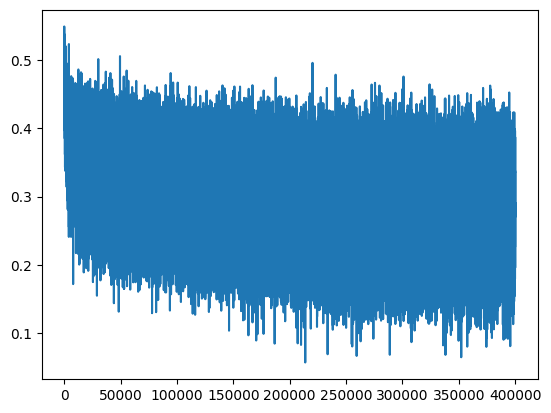

In [15]:
plt.plot(losses)

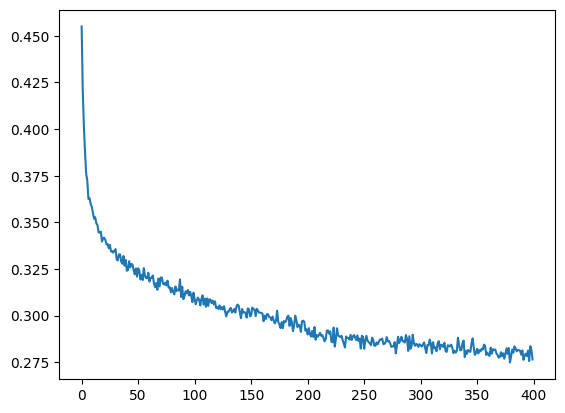

In [16]:
losses = torch.tensor(losses)
average_losses = losses.view(-1, 1000).mean(1)
plt.plot(average_losses)

In [17]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  x = model(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.8853983879089355
val 2.0246922969818115


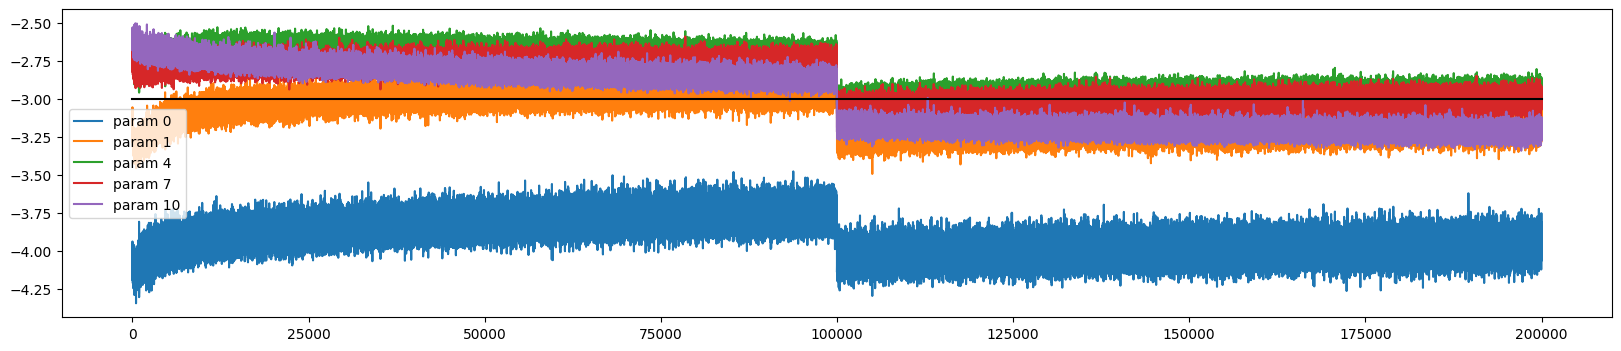

In [18]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # aim for ~1e-3
plt.legend(legends)

In [19]:
# generate samples
for _ in range(10):
    
    output = []
    # init is all ...
    context = [0] * block_size
    while True:
      # forward the nn
      x = model(torch.tensor([context]))
      dist = F.softmax(x, dim=1)

      ix = torch.multinomial(dist, num_samples=1, generator=g).item()

      context = context[1:] + [ix]
      output.append(ix)
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in output))

janezlee.
kenley.
monsleigh.
sawda.
lovene.
alena.
deular.
angelee.
oryan.
mai.
